In [1]:
import sql_tools
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def _fetch_foodorder_data(RestaurantID=1):
    cnx, cursor = sql_tools.create_session_cursor()
    query = '''
    SELECT od.order_id, od.food_id, food_name, food_type, quantity, price, order_time from 
    order_details od inner join food inner join `order`
    ON od.food_id = food.food_id AND od.order_id = `order`.order_id
    WHERE od.order_id in (
        select order_id from `order` where restaurant_id = %s
    );
    '''
    result = sql_tools.execute_fetchall(cursor, query, (RestaurantID,) )
    result = pd.DataFrame(result)

    # process data
    result.columns = ['ORDER_ID', 'FOOD_ID', 'FOOD_NAME', 'FOOD_TYPE', 'QUANTITY', 'PRICE', 'ORDER_TIME']
    result = result.astype({'QUANTITY': int})
    return result

def _process_dish_analysis(df, viewmode='D'):
    ''' Processing for the overturn analysis. This function receives food order,
        Then group by food name and date respectively.
    '''
    ans = pd.DataFrame()
    df1 = df.groupby('FOOD_NAME')
    for food_name, sub_df in df1:
        date_grouped = sub_df.groupby(pd.Grouper(key='ORDER_TIME', axis=0, freq=viewmode)).sum(numeric_only=True)
        ans[food_name] = date_grouped['QUANTITY']
    ans.index = [ans.index[i].to_pydatetime().strftime('%Y-%m-%d') for i in range(len(ans.index))]
    return ans


In [3]:
# fetch data
result = _fetch_foodorder_data()
# process data
result = _process_dish_analysis(result, 'D') 
   
result

,剁椒鱼头,口味鸡,小炒黄牛肉,有机花菜,烟笋炒腊肉,煎茄子,玉米淮山,筒骨煨湖藕,茶树菇土鸡汤,辣椒炒肉
2023-03-01,22,14,19,30,28,28,8,32,21,33
2023-03-02,18,13,22,30,25,27,10,31,25,34
2023-03-03,26,15,29,34,24,24,21,35,23,31
2023-03-04,17,10,20,34,25,28,11,33,23,33
2023-03-05,13,15,19,32,22,27,16,30,22,33
2023-03-06,17,14,23,31,25,20,16,34,26,33
2023-03-07,13,8,20,27,19,23,11,24,18,27
2023-03-08,22,9,28,34,29,28,12,36,31,34
2023-03-09,18,20,27,30,14,27,18,35,25,30
2023-03-10,14,8,23,30,25,21,12,31,21,30


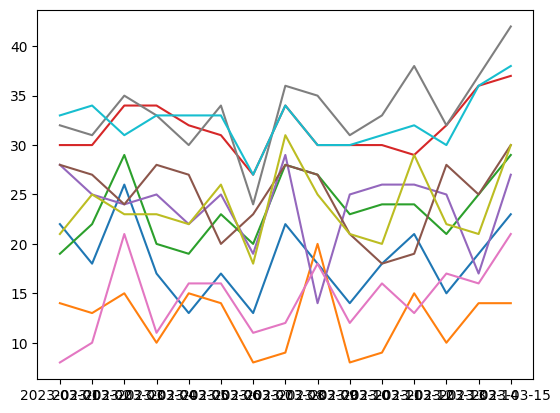

In [4]:
plt.plot(result)

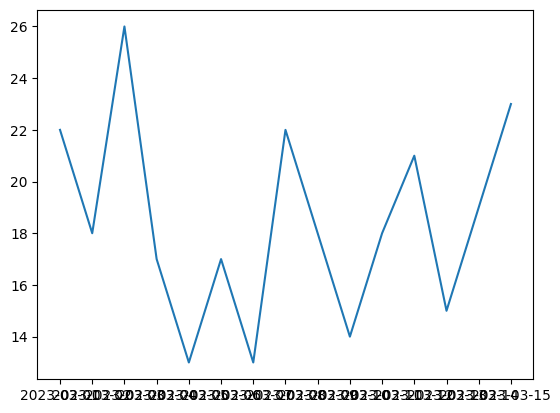

In [5]:
# Do regression:
from sklearn.linear_model import LinearRegression

line = result['剁椒鱼头']
plt.plot(line)
# Do regression here, and plot the fitted line



In [10]:
import numpy as np

def LR_predict_selling(previous: pd.DataFrame, forecast_days=5):
    X = np.arange(len(previous)).reshape(-1, 1)
    Y = previous.to_numpy()

    reg = LinearRegression().fit(X,Y)
    Predict_X = np.arange(len(previous) + forecast_days).reshape(-1, 1)

    Predict_Y = reg.predict(Predict_X)

    return Predict_Y

LR_predict_selling(result['剁椒鱼头'])

array([18.7       , 18.65714286, 18.61428571, 18.57142857, 18.52857143,
       18.48571429, 18.44285714, 18.4       , 18.35714286, 18.31428571,
       18.27142857, 18.22857143, 18.18571429, 18.14285714, 18.1       ,
       18.05714286, 18.01428571, 17.97142857, 17.92857143, 17.88571429])